<a href="https://colab.research.google.com/github/fomalhauting/Dastoon-Assignment/blob/main/assignment_dashtoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dashtoon Assignment
---
## Development of an Adaptable Deep Learning Model for Artistic Style Transfer

### This assignment aims to craft an advanced model with the ability to seamlessly integrate the aesthetic essence of one artist's masterpiece into another, bridging the gap between the computational intricacies of deep learning and the subjective realm of artistic expression. I would like to begin by showing you a before and after picture of the Main Building at IIT Roorkee, when styled against the spectacular "Starry Night".
---
### Before:
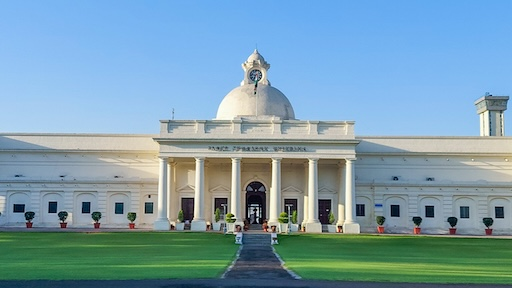

---
### After:
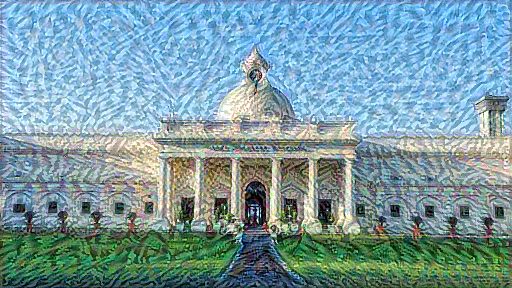

### Import Modules

In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import IPython.display as display
import time
import functools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import random

### Choose a content image and a style image

In [24]:
# Set the path to the content image file
#content_path = 'add path here'

# Set the path to the style image file
#style_path = 'add path here'

# Alternatively, you can download the image from a URL using the following lines
content_path = tf.keras.utils.get_file('photo.jpg','https://cera23.iitr.ac.in/wp-content/uploads/2023/03/IITR_JT-1.jpg')
style_path = tf.keras.utils.get_file('starry.jpg','https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT-YQpREaV8eBEIjkoG3gKa8Q9T_8OvRy4d2z_I7YI-zhjI_7x-')


In [25]:
# Set the default figure size for Matplotlib plots to 12x12 inches
mpl.rcParams['figure.figsize'] = (12,12)

# Disable grid lines in Matplotlib plots for better visualization
mpl.rcParams['axes.grid'] = False

### Function to help convert the input/output tensors into a format suitable for display


In [26]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor,dtype=np.uint8)

  # If the tensor has more than three dimensions (e.g., batch dimension), ensure it is a single image
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

  # Convert the NumPy array to a PIL Image for display
  return PIL.Image.fromarray(tensor)

### Define a function to load an image and limit its maximum dimension to 512 pixels.

In [27]:
def load_img(path_to_img):
  # Set the maximum dimension for resizing the image
  max_dim = 512

  # Read the raw image data from the file path and decode the image into a tensor
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels = 3)

  # Convert the pixel values of the image to the range [0, 1]
  img = tf.image.convert_image_dtype(img, tf.float32)

   # Get the shape of the image as a tensor of floats
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)

  # Calculate the scale factor to resize the image while maintaining its aspect ratio
  scale = max_dim / long_dim

  # Calculate the new dimensions after resizing
  new_shape = tf.cast(shape * scale, tf.int32)

  # Resize the image to the new dimensions
  img = tf.image.resize(img,new_shape)

  # Add a batch dimension to the image tensor
  img = img[tf.newaxis,:]

  return img

### Create a simple function to display the image:

In [28]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  # Display the image using Matplotlib
  plt.imshow(image)

  return img

In [29]:
# Load the content and style images using the load_img function
content_image = load_img(content_path)
style_image = load_img(style_path)

### Now load a `VGG19` without the classification head, and list the layer names

In [30]:
# Load the VGG19 model with pre-trained weights on ImageNet, excluding the top classification layer
vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')

# Display a summary of the VGG19 model architecture
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Choose intermediate layers from the network to represent the style and content of the image.

Style -> block5_conv3

Content -> block1_conv1, block2_conv1, block3_conv1,   block4_conv1, block5_conv1

In [31]:
# Define the layers to extract content and style information from the VGG19 model
content_layers =['block5_conv3']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Calculate the number of content and style layers
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model

This following function builds a VGG19 model

In [32]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""

  # Load the pre-trained VGG19 model with weights from ImageNet
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

  # Set the VGG model to be non-trainable
  vgg.trainable = False

  # Get the outputs of the intermediate layers with names specified in layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # Create a new model specifying the inputs and the desired outputs from the selected layers
  model = tf.keras.Model([vgg.input],outputs)

  return model

Calculate a gram matrix

In [33]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)   # Compute the Gram matrix using Einstein summation
  input_shape = tf.shape(input_tensor)   # Get the shape of the input tensor
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)   # Calculate the number of locations in the feature map

  # Normalize the Gram matrix by dividing it by the number of locations
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [34]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    # Constructor of the class/object, which holds all the layers and other variables of the model
    super(StyleContentModel, self).__init__()

    # Create a VGG model with both style and content layers
    self.vgg =  vgg_layers(style_layers + content_layers)

    # Store the style and content layers for later use
    self.style_layers = style_layers
    self.content_layers = content_layers

    # Calculate the number of style layers
    self.num_style_layers = len(style_layers)

    # Set the VGG model to be non-trainable
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    # Scale the input values to the range [0, 255]
    inputs = inputs*255.0

    # Preprocess the input using VGG19 preprocessing
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # Pass the preprocessed input through the VGG model
    outputs = self.vgg(preprocessed_input)

    # Separate the outputs into style and content representations
    style_outputs,content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

    # Calculate the Gram matrix for each style output
    style_outputs=[gram_matrix(style_output) for style_output in style_outputs]

    # Create dictionaries to store the content and style representations
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    # Return a dictionary containing both content and style representations
    return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [35]:
# Create an instance of the StyleContentModel to extract style and content representations
extractor =  StyleContentModel(style_layers,content_layers)

## Run gradient descent

Set your style and content target values:

In [36]:
# Get the style and content target values using the StyleContentModel
# Assuming 'extractor' is an instance of the StyleContentModel

# Extract style representations from the style image
style_targets = extractor(style_image)['style']

# Extract content representations from the content image
content_targets = extractor(content_image)['content']

# 'extractor' is assumed to be an instance of the StyleContentModel, which likely contains the necessary layers
# for extracting both style and content representations.
# 'style_image' and 'content_image' are assumed to be the style and content images, respectively.
# The extractor is used to obtain the style and content representations from their respective images.
# 'style_targets' will contain the style representations extracted from the style image.
# 'content_targets' will contain the content representations extracted from the content image.

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [37]:
# tf.Variable is used for variables we require to tweak via backpropagation
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [38]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. We are using `Adam`:

In [39]:
opt =  tf.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [40]:
style_weight   = 1e-2
content_weight = 1e4

In [41]:
def style_content_loss(outputs):
    """
    Calculate the style and content loss based on the intermediate layer representations.

    Args:
    - outputs: Dictionary containing style and content representations.

    Returns:
    - Total loss, which is a combination of style and content loss.
    """
    # Extract style and content representations from the dictionary
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Calculate style loss
    style_loss  = tf.add_n(
        [tf.reduce_mean(
        (style_outputs[name]-style_targets[name])**2)
    for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # Calculate content loss
    content_loss = tf.add_n(
        [tf.reduce_mean(
            (content_outputs[name]-content_targets[name])**2)
        for name in content_outputs.keys()
        ]
    )
    content_loss *= content_weight / num_content_layers

    # Combine style and content losses
    loss = style_loss + content_loss
    return loss

In [42]:
total_variation_weight = 30

Use `tf.GradientTape` to update the image.

In [43]:
@tf.function()
def train_step(image):
  # Use tf.GradientTape to record operations for automatic differentiation
  with tf.GradientTape() as tape:
    # Pass the image through the model to obtain style and content representations
    outputs = extractor(image)
    # Calculate the total loss, which includes style, content, and total variation losses
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  # Calculate the gradient of the loss with respect to the image
  grad = tape.gradient(loss,image)

  # Apply the gradient to perform an optimization step using the specified optimizer
  opt.apply_gradients([(grad,image)])

  # Clip the pixel values of the image to be within the [0, 1] range
  image.assign(clip_0_1(image))

Now lets optimize the content image and get the final result:

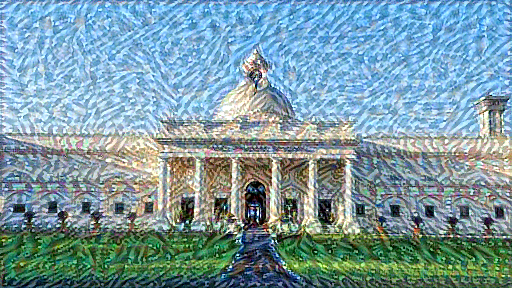

Total number of training steps: 20
Total time taken to train: 2.7


In [44]:
import time

# Record the starting time
start = time.time()

# Define the number of epochs and steps per epoch
epochs = 10
steps_per_epoch = 2

# Initialize the total training steps
step = 0

# Training loop
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    # Perform a training step to optimize the image
    train_step(image)

  # Display the current state of the optimized image after each epoch
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Total number of training steps: {}".format(step))

# Record the ending time
end = time.time()

# Calculate and print the total time taken for training
print("Total time taken to train: {:.1f}".format(end-start))